**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

/home/ubuntu/fastai/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

Split dataframe in train and validation:

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

Define root mean square error and function to print score

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

Baseline

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=16, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 57s, sys: 1.22 s, total: 2min 58s
Wall time: 17.4 s
[0.11927970720559022, 0.23007502457595244, 0.970264999176316, 0.9054662408198783, 0.9114630471685576]


###### Trick if RandomForrestRegressor should run multiple times -  Or just good practice

Each time the RandomForestRegressor is launch it will convert our elements into dtype=np.float32. Therefore, if we do this once, we are able to save this operation each time we run the RandomForestregressor, hence save time if the RandomForestRegressor is conducted multiple times. 

In [10]:
%time x=np.array(X_train, dtype=np.float32)

CPU times: user 1.14 s, sys: 328 ms, total: 1.47 s
Wall time: 1.47 s


In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(x, y_train)
print_score(m)

CPU times: user 2min 56s, sys: 338 ms, total: 2min 57s
Wall time: 15.8 s
[0.11915752322044085, 0.22865366933010453, 0.9703258859806682, 0.9066306524035852, 0.9116823941463688]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [15]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.64 s, sys: 52 ms, total: 1.69 s
Wall time: 1.69 s


(9.171020739656479, 0.15731741138796168)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [16]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 300 ms, sys: 277 ms, total: 577 ms
Wall time: 789 ms


(9.171020739656479, 0.15731741138796168)

Preds is a matrixs with size observation times trees/estimators

We can see that different trees are giving different estimates for this auction. In order to see how prediction confidence varies, we can add this into our dataset.

We create a new dataframe based on our validation set and add the two columns "standard deviation" and "prediction" to it. Next, we plot the "Enclosure" feature as a function of observations in form om a boxdiagram.   

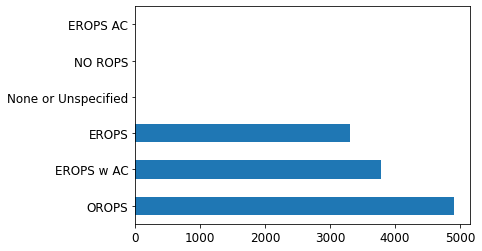

In [17]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

x["pred_std"] = standard diviation over all estimators.
x['pred'] = mean over all predictions from all estimatores

As see above only three values is used in this feature. Where OROPS have most observations. 

Addtionally, we use show the mean of the actual saleprice, our predictions and the standard deviation grouped by Enclosure.

In [27]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby(flds[0], as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.844672,0.245268
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.594352,0.228084
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.680031,0.201610


The above table can be depicted as barplot as below:

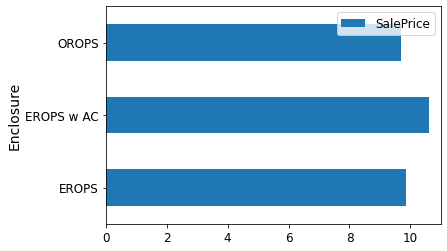

In [28]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

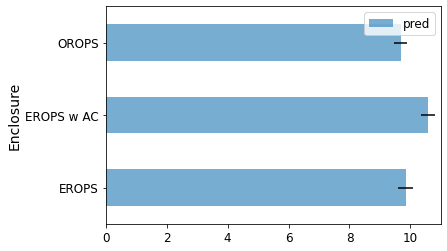

In [29]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

Caculating the ratio between the standard deviation and the predtions, will tell us where the predictions are less accurate. 

In [30]:
enc_summ = x[flds].groupby(flds[0]).mean()
(enc_summ.pred_std/enc_summ.pred).sort_values(ascending=False)

Enclosure
EROPS                  0.024914
EROPS w AC             0.021529
OROPS                  0.020827
EROPS AC                    NaN
NO ROPS                     NaN
None or Unspecified         NaN
dtype: float64

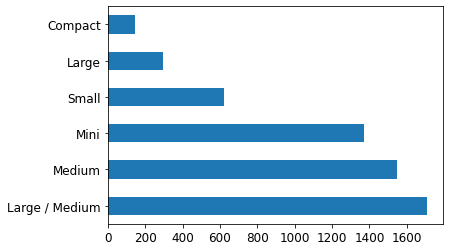

In [31]:
raw_valid.ProductSize.value_counts().plot.barh();

In [32]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby('ProductSize',as_index=False).mean()
summ

,ProductSize,SalePrice,pred,pred_std
0,Compact,9.735093,9.822804,0.290360
1,Large,10.470589,10.410906,0.328087
2,Large / Medium,10.691871,10.669164,0.262089
3,Medium,10.681511,10.629373,0.238882
4,Mini,9.535147,9.562711,0.224767
5,Small,10.324448,10.343297,0.272110


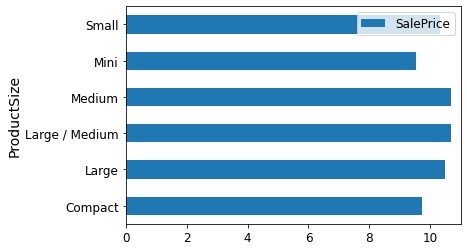

In [33]:
summ = summ[~pd.isnull(summ.SalePrice)]
summ.plot(flds[0], 'SalePrice', 'barh', xlim=(0,11));

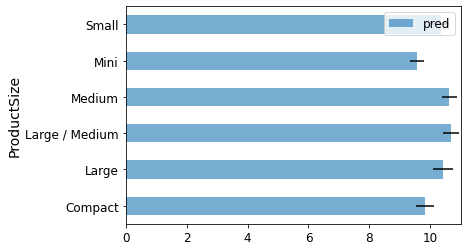

In [34]:
summ.plot(flds[0],'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

Caculating the ratio between the standard deviation and the predtions, will tell us where the predictions are less accurate. 

In [35]:
summ = x[flds].groupby('ProductSize').mean()
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.031514
Compact           0.029560
Small             0.026308
Large / Medium    0.024565
Mini              0.023505
Medium            0.022474
dtype: float64

# Feature importance - usually first thing to look at! 

Normally in industry and academic enviroment feature importance is usually observed in some kind of linear regression, logistic regression or general linear models. Using these models, one take note of the coefficients and depending on their magnitude the importance of is observed. There is this trop out there that this is somehow more accurate, more pure, in some way better way of doing feature importance, but that couldn’t be farther from the truth

If you think about it, if you were missing an interaction, if you were missing a transformation you needed, or if you have any way being anything less than a 100% perfect in all of your pre-processing so that your model is the absolute correct truth of the situation — unless you’ve got all of that correct, then your coefficients are wrong. Your coefficients are telling you “in your totally wrong model, this is how important those things are” which is basically meaningless. 

Where else, the random forest feature importance is telling you in this extremely high parameter, highly flexible functional form, with few if any statistical assumptions, this is your feature importance. 

Therefore, be very cautions about logistic regression coefficients. Furthermore, if they’ve done so much pre-processing that actually the model is pretty accurate then now you are looking at coefficients that are going to be like a coefficient of some principal component from a PCA or a coefficient of some distance from some cluster or something. At which point, they are very very hard to interpret anyway. They are not actual variables. So they are kind of the two options I’ve seen when people try to use classic statistical techniques to do a variable importance equivalent.

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [36]:
fi = rf_feat_importance(m, X_train); fi[:11]

,cols,imp
5,YearMade,0.170014
37,Coupler_System,0.128142
13,ProductSize,0.107182
14,fiProductClassDesc,0.071325
2,ModelID,0.054450
63,saleElapsed,0.052987
10,fiSecondaryDesc,0.045726
19,Enclosure,0.041908
8,fiModelDesc,0.033573
38,Grouser_Tracks,0.031487


https://pandas.pydata.org/pandas-docs/version/0.15.2/generated/pandas.DataFrame.plot.html

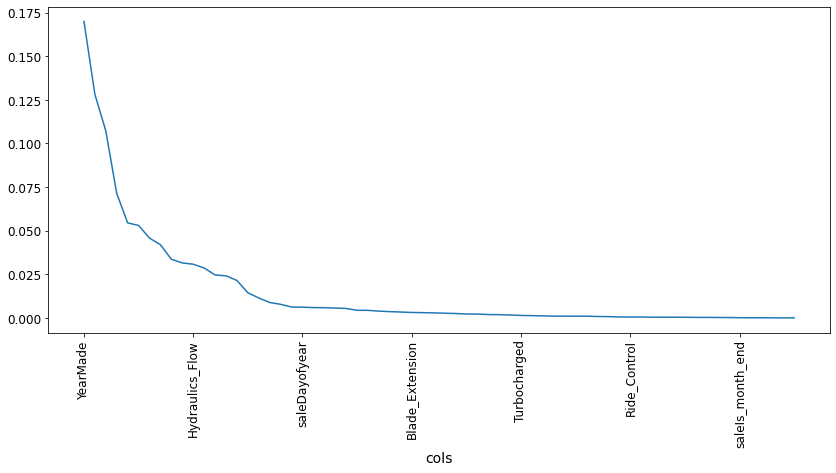

In [37]:
fi.plot('cols', 'imp', figsize=(14,6), legend=False, rot=90);

In [43]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

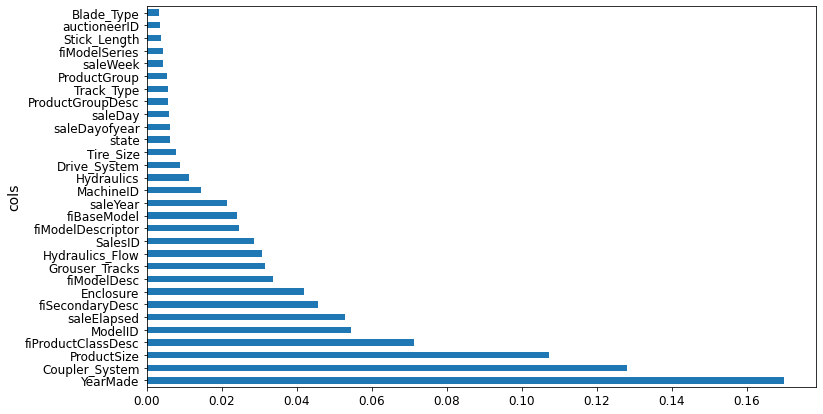

In [45]:
plot_fi(fi[:30]);

In the above plot look for the natural break ad study the most important features carefully! Consult we others aboute this features as figure out if there is something we can do sharpen these features! (reduce noise etc). Furthermore, make sure that it make sense that these features are the most important.

As seen above only a dosen features are of importance. Therefore, for speeding things up we want to discard those featurs that have less than 0.5% importants for the RandomForestRegressor.  

In [46]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [47]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

After creating a new X_train we run our RandomForestRegressor once again.

In [48]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 51s, sys: 295 ms, total: 1min 51s
Wall time: 9.96 s
[0.12461070222600218, 0.22483824138922545, 0.967547697693891, 0.9097206687322449, 0.910074749042956]


By discarding redundant features we have almost half the CPU times. Furthermore, we have improved our model a bit, as we have making spilting easier for the regressor by removeing redundant features. 

Previous results:
CPU times: user 3min 24s, sys: 509 ms, total: 3min 25s
Wall time: 17.9 s
[0.11920303508749704, 0.22833011540109185, 0.9703032137697971, 0.906894708039957, 0.9116337392845516]

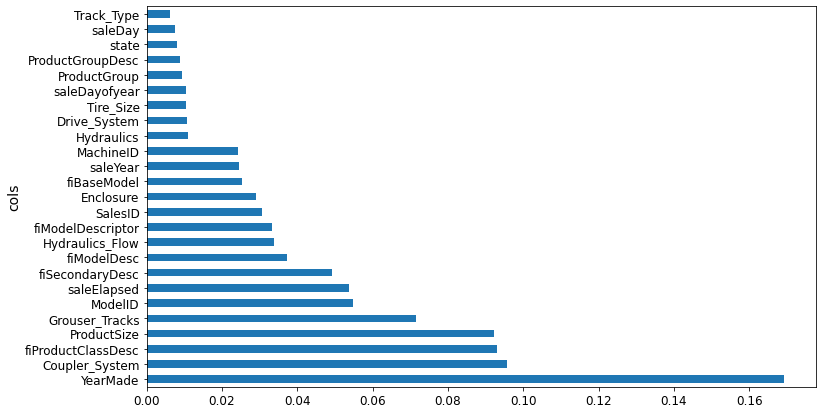

In [49]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

Key thing that has happened is that when you remove redundant columns, you are also removing sources of collinearity. In other words, two columns that might be related to each other. Collinearity does not make your random forests less predictive, but if you have a column A is a little bit related to a column B, and B is a strong driver of the independent, what happens is that the importance is going to be split between A and B. By removing some of those columns with very little impact, it makes your feature importance plot clearer. Before YearMade was pretty close to Coupler_System. But there must have been a bunch of things that are collinear with YearMade and now you can see YearMade really matters. This feature importance plot is more reliable than the one before because it has a lot less collinearity to confuse us.

#### rf_feat_importance

Interestingly, almost no one knows this. Many people will tell you there is no way of interpreting this particular kind of model (the most important interpretation of a model is knowing which things are important) and that is almost certainly not going to be true because the technique I am going to teach you actually works for any kind of models.

- We take our bulldozer data set and we have a column Price we are trying to predict (dependent variable, Target).

- We have 25 independent variables and one of them is YearMade.

- How do we figure out how important YearMade is? We have a whole random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price (in this case, we get our root mean squared error and r²). This is our starting point.

- Let’s do exactly the same thing, but this time, take the YearMade column and randomly shuffle it (i.e. randomly permute just that column). Now YearMade has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we totally randomly reordered it.

- Before, we might have found our r² was .89. After we shuffle YearMade, we check again, and now r² is .80. The score got much worse when we destroyed that variable.

- Okay, let’s try again. We put YearMade back to how it was, and this time let’s take Enclosure and shuffle that. This time, r²is .84 and we can say the amount of decrease in our score for YearMade was .09 and the amount of decrease for Enclosure was .05. And this is going to give us our feature importances for each column.

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the `max_n_cat`argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [50]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 7s, sys: 1.66 s, total: 5min 8s
Wall time: 31.4 s
[0.11806514722207904, 0.23412004947199924, 0.970867466663971, 0.9021129617331052, 0.910467550933579]


As one-hot encodeing have created addtional columns, our model is more compute computationally costly. Moreover, in this case it made our model less predective(depend on specific model). Nevertheless: 

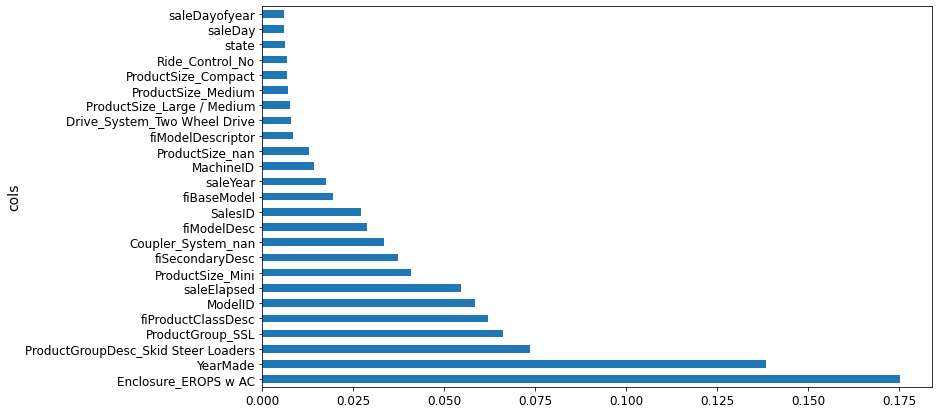

In [51]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Even though our model yeilded slight worse results, for feature importance one-hot encodeing is always important as we see now that Enclosure_EROPS w AC is more important than YearMade.

# Removing redundant features

We’ve already seen how variables which are basically measuring the same thing can confuse our variable importance. They can also make our random forest slightly less good because it requires more computation to do the same thing and there’re more columns to check. So we are going to do some more work to try and remove redundant features. The way I do that is to do something called “dendrogram”. And it is kind of hierarchical clustering.

In [52]:
from scipy.cluster import hierarchy as hc

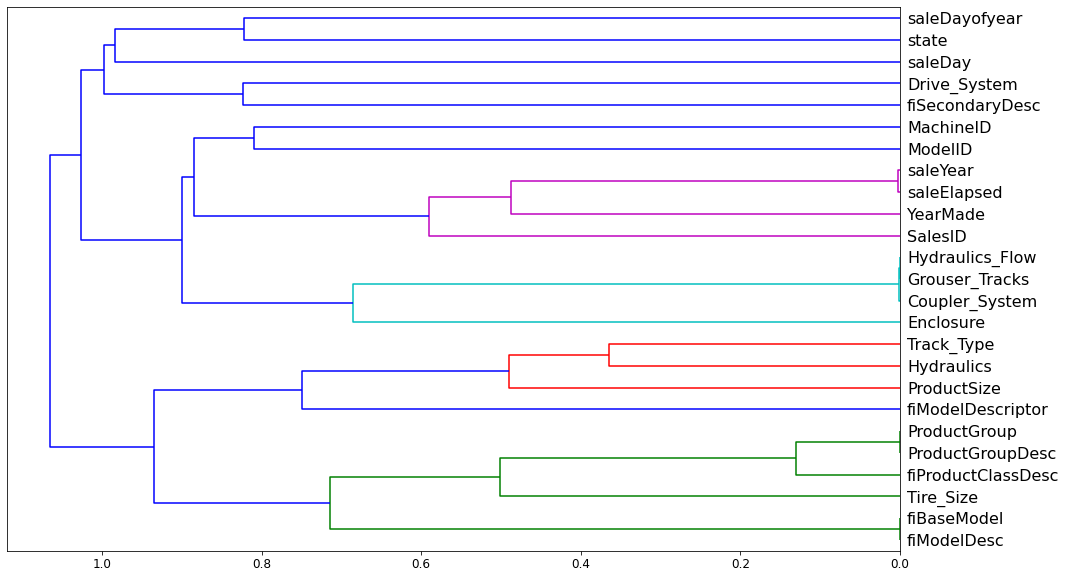

In [53]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Spearman’s R - looking at ranking vs. a field - Convert everything to rank, then calculate the correlation coefficient.

Like so, we can see which two variables are the most similar. `saleYear` and `saleElapsed` are very similar. So the horizontal axis here is how similar are the two points that are being compared. If they are closer to the right, that means that they are very similar. So saleYear and saleElapsed have been combined and they were very similar.

Another way could be a heatmap. However, the above is easier to see. 

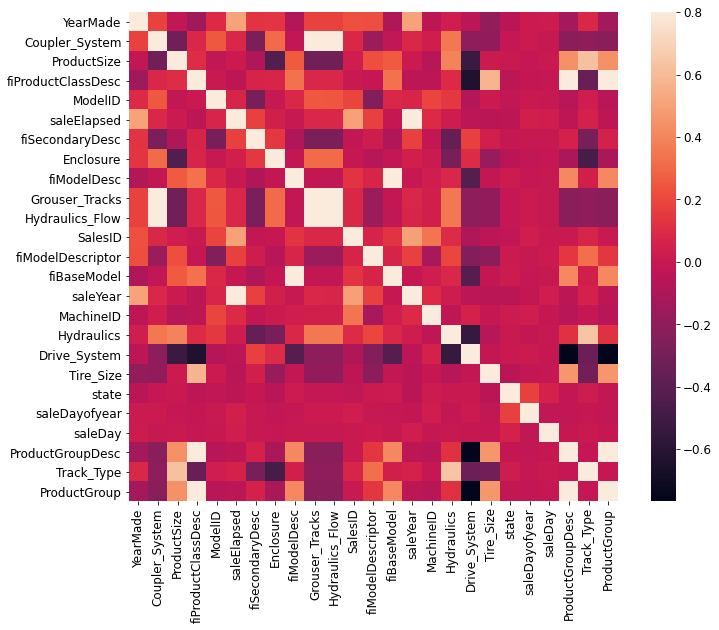

In [54]:
#correlation matrix
corrmat = df_keep.corr(method ="spearman")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [55]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    %time m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [56]:
get_oob(df_keep)

CPU times: user 2min 8s, sys: 367 ms, total: 2min 9s
Wall time: 11.1 s


0.9086595437188911

Now we try removing each variable one at a time.

In [41]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks','Hydraulics_Flow', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

CPU times: user 2min 1s, sys: 120 ms, total: 2min 1s
Wall time: 10.6 s
saleYear 0.9079567376593937
CPU times: user 1min 53s, sys: 47.7 ms, total: 1min 53s
Wall time: 10 s
saleElapsed 0.906421586156305
CPU times: user 2min, sys: 52.1 ms, total: 2min
Wall time: 10.6 s
fiModelDesc 0.9074517800804212
CPU times: user 2min, sys: 63.9 ms, total: 2min
Wall time: 10.5 s
fiBaseModel 0.9080931219476812
CPU times: user 2min 5s, sys: 59.6 ms, total: 2min 5s
Wall time: 10.8 s
Grouser_Tracks 0.9084894448441456
CPU times: user 2min 2s, sys: 35.6 ms, total: 2min 2s
Wall time: 10.6 s
Hydraulics_Flow 0.9080978721760248
CPU times: user 2min 5s, sys: 63.5 ms, total: 2min 5s
Wall time: 10.9 s
Coupler_System 0.9080303269568268


It looks like we can try one from each group for removal. Let's see what that does.

In [57]:
to_drop = ['saleYear', 'fiBaseModel', 'Hydraulics_Flow']
get_oob(df_keep.drop(to_drop, axis=1))

CPU times: user 1min 56s, sys: 152 ms, total: 1min 56s
Wall time: 10.1 s


0.9077784244809235

our result is slightly worse but by removing colums we have a more simple model so let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [58]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [59]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [60]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [61]:
reset_rf_samples()

In [62]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 46s, sys: 152 ms, total: 1min 46s
Wall time: 9.57 s
[0.12500363134119535, 0.22769161632801077, 0.9673427143580102, 0.9074146965946148, 0.9087960963557232]


##### Recap: Feature importance - very key for finding top features



- Few features have most of the importance: Find only the feature importances over a certain threshold

- Collinearity distributes importance: random forests deal with collinearity very well, but one by-product is that collinear fields will ‘steal’ importance. The total importance will be distributed between the column.

- Feature filtering will consolidate importance: Feature importance filtering and recalculating will reconsolidate importance in the key fields

- We can also loop an shuffle columns and compare the performance with the column shuffled. It’s a good indicator for finding important features.

# Partial dependence

Really inderstand you data better. What we are going to do is we are going to find out, for the features that are important, how do they relate to the dependent variable. 

In [48]:
from pdpbox import pdp
from plotnine import *

Again, since we are doing interpretation, we will set set_rf_samples to 50,000 to run things quickly.

In [49]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [50]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
%time m.fit(X_train, y_train);

CPU times: user 5min 14s, sys: 1.63 s, total: 5min 16s
Wall time: 26.9 s


RandomForestRegressor(max_features=0.6, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

Here is the top 10 most important features

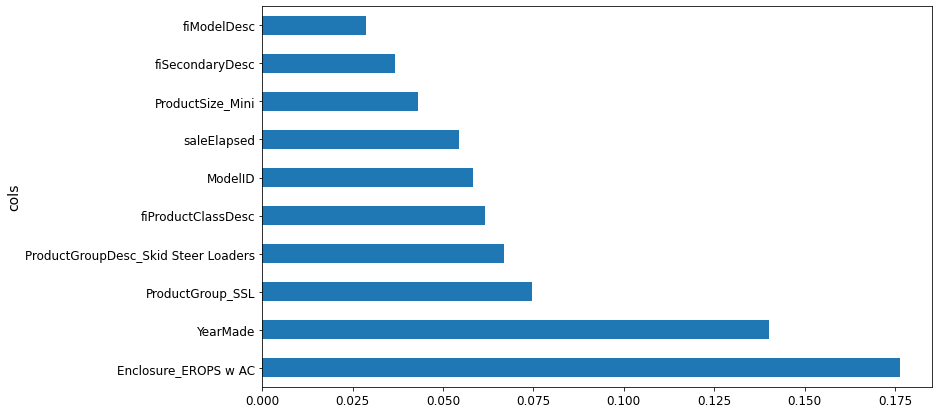

In [51]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

Let’s try to learn more about those top 10. `YearMade` is the second most important. So one obvious thing we could do would be to plot`YearMade` against `saleElapsed` because as we’ve talked about already, it seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting `YearMade` against `saleElapsed` to see how they relate to each other.

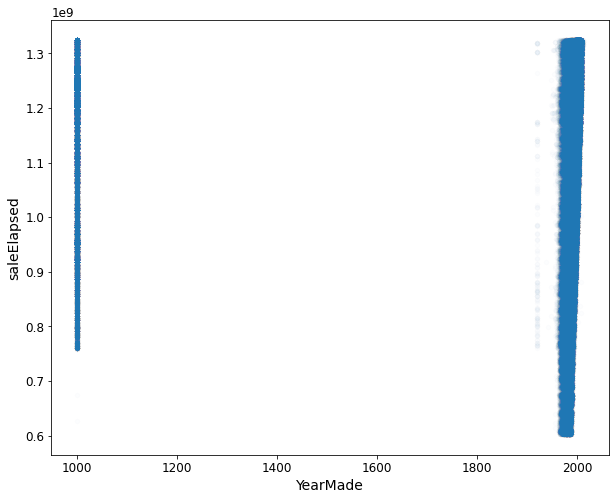

In [52]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

Apparently `Yearmade`have a bunch of observation that are a thousand. Probably, the client lacks the information and thousand have been written instead. 

So in ordre to understand the plot better lets remove these obervations.

In [53]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

Let’s now look at the relationship between YearMade and SalePrice. There is a really great package called ggplot. ggplot originally was an R package (GG stands for the Grammar of Graphics)

The R version is much better documented so you should read its documentation to learn how to use it. But basically you say “okay, I want to create a plot for this data frame (x_all). When you create plots, most of the datasets you are using are going to be too big to plot. For example, if you do a scatter plot, it will create so many dots that it’s just a big mess and it will take forever. Remember, when you are plotting things, you are looking at it, so there is no point plotting something with a hundred million samples when if you only used a hundred thousand, it’s going to be pixel identical. That’s why I call get_sample first. get_sample just grabs a random sample.

By adding standard error equals true (se=True), it also shows me the confidence interval of this smoother. loess stands for locally weighted regression which is this idea of doing lots of little mini regressions.

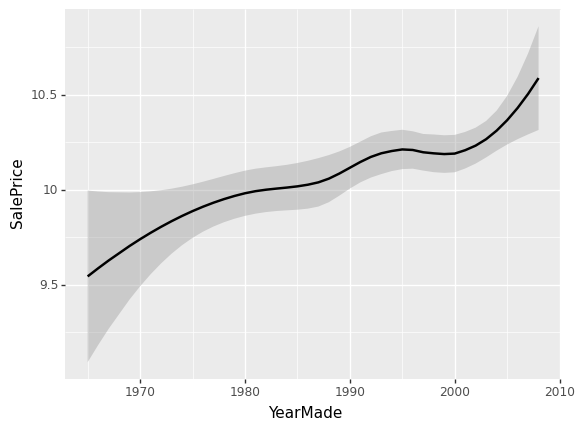

<ggplot: (-9223363278018436359)>

In [54]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

Plot depict an unexpected relationship between YearMade and SalePrice. We would expect that newer machine to me more expensive because of inflation and condition. The problem is that when you look at a univariate relationship like this, there is a whole lot of collinearity going on — a whole lot of interactions that are being lost. For example, why did the price drop? Is it actually because things made between 1991 and 1997 are less valuable? Or is it actually because most of them were also sold during that time and there was maybe a recession then? Or maybe it was because products sold during that time, a lot more people were buying types of vehicles that were less expensive? There’s all kind of reasons for that. 

These univariate charts is common at the companies, people will come to you with univariate charts where they’ll say “oh my gosh, our sales in Chicago have disappeared” or “people aren’t clicking on this add anymore” and they will show you a chart that looks like this and ask what happened. Most of the time, you’ll find the answer to the question “what happened” is that there is something else going on. So for instance, “actually in Chicago last week, actually we were doing a new promotion and that’s why our revenue went down — it’s not because people are not buying stuff in Chicago anymore; the prices were lower”.

So what we really want to be able to do is say “well, what’s the relationship between `SalePrice` and `YearMade` all other things being equal. “All other things being equal” basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price? To do that, we do something called a partial dependence plot. 

In [55]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

Using the pdp library we will create the partial dependence plots(all other things being equal). 


So we’ve got our sample of 500 data points. For the `YearMade`column we are going to incrementally replace the `YearMade` value from lowest to highest value while all of the other data is going to be exactly the same(all other things being equal in year xxxx). Hence, every row of our 500 data points `yearmade= xxxx` and all of the other untoched. 

Next, we are going to take our random forest model `m` and pass all this through our random forest model to predict the sale price. That will tell us for everything that was auctioned, how much do we think it would have been sold for if that thing was made in year. And that’s what we are going to plot. And we are going to do the same thing for year+1 until highst year is reached. 



Question: To be clear, we’ve already fit the random forest and then we are just passing a new year and seeing what it determines the price should be? Yes, so this is a lot like the way we did feature importance. But rather than randomly shuffling the column, we are going to replace the column with a constant value. Randomly shuffling the column tells us how accurate it is when you don’t use that column anymore. Replacing the whole column with a constant estimates for us how much we would have sold that product for in that auction on that day in that place if that product had been made in 1961. We then take the average of all of the sale prices that we calculate from that random forest.

In [56]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


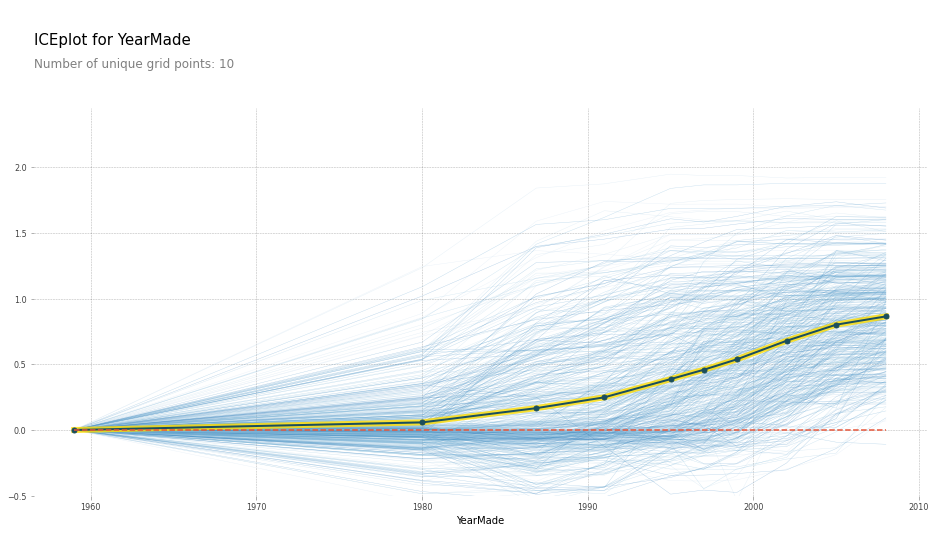

In [57]:
plot_pdp('YearMade')

Each light blue line in the partial dependence plot(PDP) depict a bulldozer in our little dataset where we have changed the yearmade value(1960...2008) and predicted the saleprice for each year. (1960 is index that to zero)   

We actually plot all 500 predictions of how much every one of those 500 auctions would have gone for if we replaced its YearMade with each of these different values. 

The black/yellow line is the average. So this tells us how much would we have sold on average all of those auctions for if all of those products were actually made in 1985, 1990, 1993, etc. So you can see, what’s happened here is at least in the period where we have a reasonable amount of data which is since 1990, this is basically a totally straight line — which is what you would except. Because if it was sold on the same date, and it was the same kind of tractor, sold to the same person in the same auction house, then you would expect more recent vehicles to be more expensive because of inflation and they are newer. You would expect that relationship to be roughly linear and that is exactly what we are finding. By removing all these externalities, it often allows us to see the truth much more clearly.

This partial dependence plot is something which is using a random forest to get us a more clear interpretation of what’s going on in our data. The steps were:

- First of all look at the future importance to tell us which things do we think we care about.

- Then to use the partial dependence plot to tell us what’s going on on average.

There is another cool thing we can do with PDP which is we can use clusters. What clusters does is it uses cluster analysis to look at each one of the 500 rows and say do some those 500 rows move in the same way. We could kind of see it seems like there’s a whole a lot of rows that go down and then up, and there seems to be a bunch of rows that go up and then go flat. It does seem like there’s some kind of different types of behaviors being hidden and so here is the result of doing that cluster analysis:

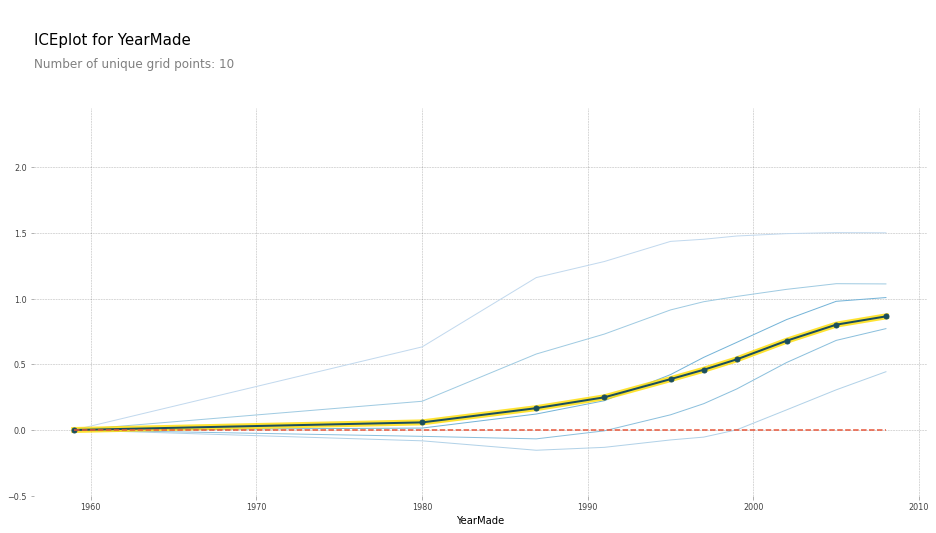

In [58]:
plot_pdp('YearMade', clusters=5)

We still get the same average but it says here are five most common shapes that we see. And this is where you could then go in and say all right, it looks like some kinds of vehicle, after 1990, their prices are pretty flat. Before that, they were pretty linear. Some other kinds of vehicle were exactly the opposite, so different kinds of vehicle have these different shapes. So, this is something you could dig into.


Question: So what are we going to do with this information [1:21:40]? The purpose of interpretation is to learn about a dataset and so why do you want to learn about a dataset? It’s because you want to do something with it. So in this case, it’s not so much something if you are trying to win a Kaggle competition — it can be a little bit like some of these insights might make you realize I could transform this variable or create this interaction, etc. Obviously feature importance is super important for Kaggle competitions. But this one is much more for real life. So this is when you are talking to somebody and you say to them “okay, those plots you’ve been showing me which actually say that there was this kind of dip in prices based on things made between 1990 and 1997. There wasn’t really. Actually they were increasing, and there was something else going on at that time.” It’s basically the thing that allows you to say for whatever this outcome I’m trying to drive in my business is, this is how something is driving it. So if it’s like I’m looking at advertising technology, what’s driving clicks that I I’m actually digging in to say okay, this is actually how clicks are being driven. This is actually the variable that’s driving it. This is how it’s related. So therefore, we should change our behavior in this way. That’s really the goal of any model. I guess there are two possible goals: one goal of a model is just to get the predictions, like if you are doing hedge fund trading, you probably want to know what the price of that equity is going to be. If you are doing insurance, you probably just want to know how much claims that guy is going to have. But probably most of the time, you are actually trying to change something about how you do business — how you do marketing, how you do logistics, so the thing you actually care about is how the things are related to each other.

Question: So what are we going to do with this information [1:21:40]? The purpose of interpretation is to learn about a dataset and so why do you want to learn about a dataset? It’s because you want to do something with it. So in this case, it’s not so much something if you are trying to win a Kaggle competition — it can be a little bit like some of these insights might make you realize I could transform this variable or create this interaction, etc. Obviously feature importance is super important for Kaggle competitions. But this one is much more for real life. So this is when you are talking to somebody and you say to them “okay, those plots you’ve been showing me which actually say that there was this kind of dip in prices based on things made between 1990 and 1997. There wasn’t really. Actually they were increasing, and there was something else going on at that time.” It’s basically the thing that allows you to say for whatever this outcome I’m trying to drive in my business is, this is how something is driving it. So if it’s like I’m looking at advertising technology, what’s driving clicks that I I’m actually digging in to say okay, this is actually how clicks are being driven. This is actually the variable that’s driving it. This is how it’s related. So therefore, we should change our behavior in this way. That’s really the goal of any model. I guess there are two possible goals: one goal of a model is just to get the predictions, like if you are doing hedge fund trading, you probably want to know what the price of that equity is going to be. If you are doing insurance, you probably just want to know how much claims that guy is going to have. But probably most of the time, you are actually trying to change something about how you do business — how you do marketing, how you do logistics, so the thing you actually care about is how the things are related to each other.

Comment: Bulldozers made in 2010 probably are not close to the type of bulldozers that were made in 1960. If you are taking something that would be so very different, like a 2010 bulldozer, and then trying to just drop it to say “oh if it was made in 1960” that may cause poor prediction at a point because it’s so far outside of the training set [1:26:12]. Absolutely. That’s a good point. It is a limitation, however, if you’ve got a datapoint that’s in a part of the space that it has not seen before, like maybe people didn’t put air conditioning in bulldozers in 1960 and you are saying how much would this bulldozer with air conditioning would have gone for in 1960, you don’t really have any information to know that. This is still the best technique I know of but it’s not perfect. And you kind of hope that the trees are still going to find some useful truth even though it hasn’t seen that combination of features before. But yeah, it’s something to be aware of.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


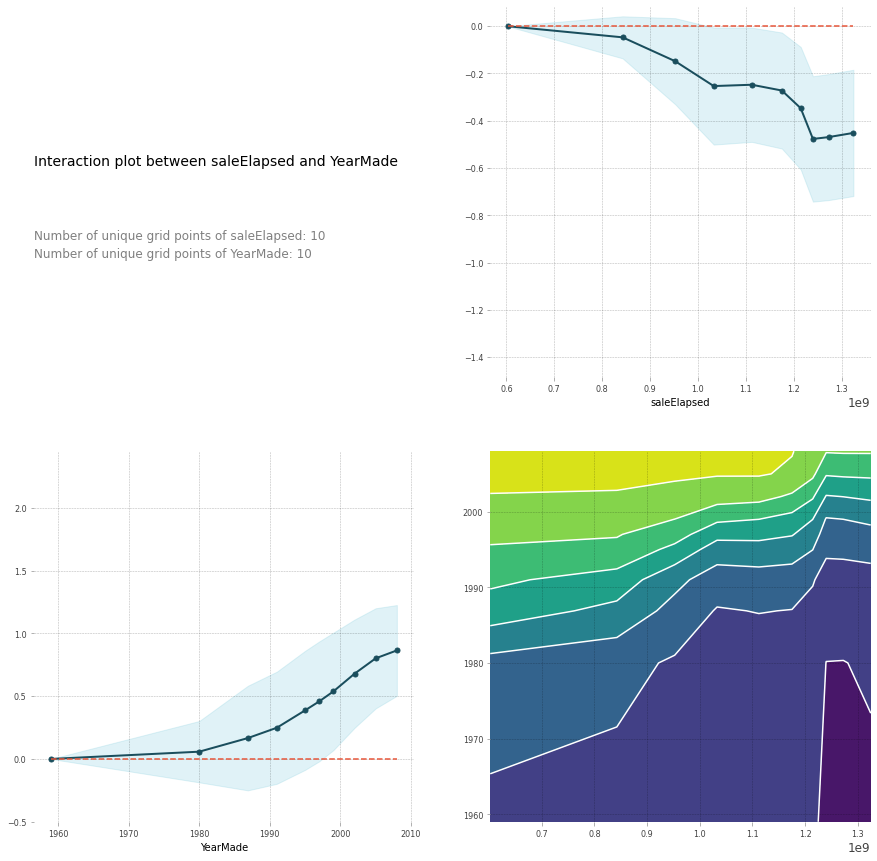

In [59]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

You can also do the same thing in a PDP interaction plot [1:27:36]. And PDP interaction plot which is really what I’m trying to get to here is how does saleElapsed and YearMade together impact the price. If I do a PDP interaction plot, it shows me saleElapsed vs. price, YearMade vs. price, and the combination vs. price. Remember, this is always log of price. That’s why these prices look weird. You can see that the combination of saleElapsed and YearMade is as you would expect —the highest prices are those where there’s the least elapsed and the most recent year made. The upper right is the univariate relationship between saleElapsed and price, the lower left is the univariate relationship between YearMade and price, and the lower right is the combination of the two. It’s enough to see clearly that these two things are driving price together. You can also see these are not simple diagonal lines so there is some interesting interaction going on. Based on looking at these plots, it’s enough to make me think, oh, we should maybe put in some kind of interaction term and see what happens. So let’s come back to that in a moment, but let’s just look at a couple more.

Remember, in this case, we did one-hot-encoding — way back at the top, we said max_n_cat=7. So we have things like Enclosure_EROPS w AC. So if you have one-hot-encoded variables, you can pass an array of them to plot_pdp and it will treat them as a category.

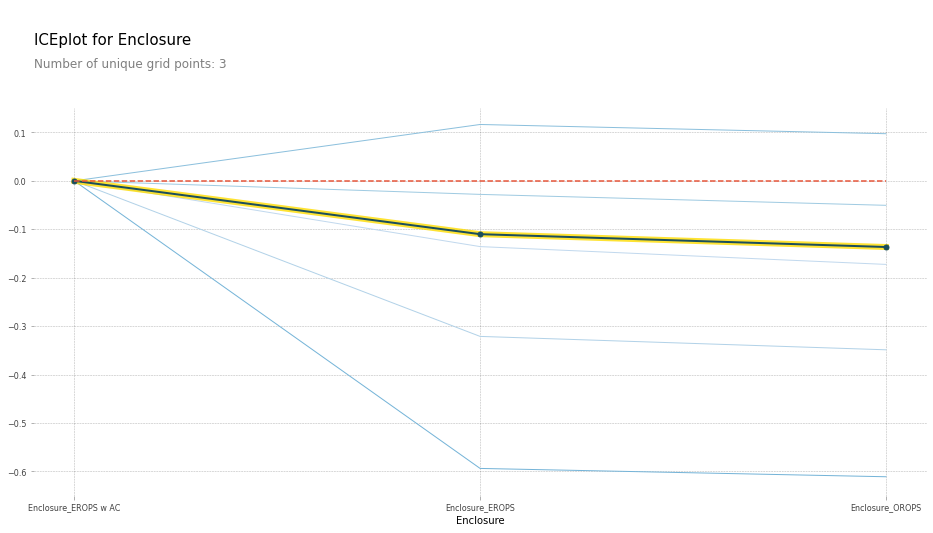

In [60]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

I can see here that Enclosure_EROPS w AC on average are more expensive than Enclosure_EROPS or Enclosure_OROPS. It actually looks like the latter two are pretty similar or else Enclosure_EROPS w AC is higher. So at this point, I’m probably being inclined to hop on to Google and type “erops orops” and find out what these things are and here we go.

So it turns out that EROPS is enclosed rollover protective structure and so it turns out that if your bulldozer is fully enclosed then optionally you can also get air conditioning. So actually this thing is telling us whether it has air conditioning. If it’s an open structure, then obviously you don’t have air conditioning at all. So that’s what these three levels are. So we’ve now learnt all other things being equal, the same bulldozer, sold at the same time, built at the same time, sold to the same person is going to be quite a bit more expensive if it has air conditioning than if it doesn’t. So again, we are getting this nice interpretation ability. Now that I spent some time with this dataset, I’d certainly noticed that knowing this is the most important thing, you do notice that there is a lot more air conditioned bulldozers nowadays than they used to be and so there is definitely an interaction between date and that.

In [87]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

/home/ubuntu/fastai/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/fastai/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CPU times: user 2min 3s, sys: 71.5 ms, total: 2min 3s
Wall time: 9.01 s


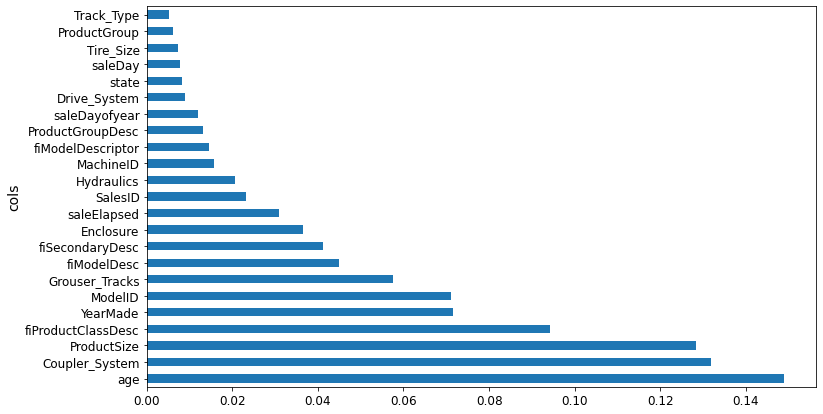

In [88]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
%time m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

Based on the earlier interaction analysis, I’ve tried, first of all, setting everything before 1950 to 1950 because it seems to be some kind of missing value [1:31:25]. I’ve set age to be equal to saleYear - YearMade. Then I tried running a random forest on that. Indeed, age is now the single biggest thing, saleElapsed is way back down here, YearMade is back down here. So we’ve used this to find an interaction. But remember, of course a random forest can create an interaction through having multiple split points, so we shouldn’t assume that this is actually going to be a better result. And in practice, I actually found when I looked at my score and my RMSE, adding age was actually a little worse. We will see about that later probably in the next lesson.


# Tree interpreter

One last thing is tree interpreter. This is also in the category of things that most people don’t know exists, but it’s super important. Almost pointless for Kaggle competitions but super important for real life. Here is the idea. Let’s say you are an insurance company and somebody rings up and you give them a quote and they say “oh, that’s $500 more than last year. Why?” So in general, you’ve made a prediction from some model and somebody asks why. This is where we use this method called tree interpreter. What tree interpreter does is it allows us to take a particular row.

In [64]:
from treeinterpreter import treeinterpreter as ti

In [65]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

So in this case, we are going to pick row number zero.

In [66]:
row = X_valid.values[None,0]; row

array([[      1999,          0,         17,          5,        665, 1284595200,          0,          0,
                 0,          1,       3232,    4364751,         11,          4,    2300944,          4,
                 2,         35,        259,         16,          0,         11]])

What I can do with a tree interpreter is I can go ti.predict, pass in my random forest and my row (so this would be like this particular customer’s insurance information, or in this case this particular auction). And it will give me back three things:

- prediction: The prediction from the random forest
- bias: The average sale price across the whole original dataset
- contributions: A column and the value to split by (i.e. the predictor), and how much it changed the predicted value.

In [67]:
prediction, bias, contributions = ti.predict(m, row)

In [68]:
prediction[0], bias[0]

(array([9.25497]), 10.105443482887715)

In [69]:
idxs = np.argsort(contributions[0])

So here is all of our predictors and the value of each

In [70]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5740473154530549),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.17785551336877375),
 ('age', 11, -0.1349205032501231),
 ('fiModelDesc', 'KX1212', -0.10530419834745537),
 ('fiSecondaryDesc', nan, -0.06325796682327285),
 ('saleElapsed', 1284595200, -0.018143136769422075),
 ('Enclosure', 'EROPS', -0.016291905083026935),
 ('SalesID', 4364751, -0.006533207468829527),
 ('fiModelDescriptor', nan, -0.00558264627024947),
 ('ProductGroupDesc', 'Track Excavators', -0.0021967900260034144),
 ('ProductGroup', 'TEX', -0.000325734179472148),
 ('ModelID', 665, 0.0023697803218656333),
 ('Drive_System', nan, 0.00300298823317533),
 ('saleDayofyear', 259, 0.007160760211351658),
 ('state', 'Ohio', 0.011540905992222461),
 ('saleDay', 16, 0.01212603342367422),
 ('Hydraulics', 11, 0.014156382723458493),
 ('Track_Type', 'Steel', 0.015744644370869178),
 ('MachineID', 2300944, 0.0172288828336117),
 ('Grouser_Tracks', nan, 0.023649646035193372),


In [71]:
contributions[0].sum()

-0.8504772439115038

So a contribution of -0.8504772 is given for row zero compared to the bias(The average sale price across the whole original dataset). 

In [77]:
bias[0]+contributions[0].sum()

9.25496623897621

# Extrapolation

Baseline for comparison: Our model from section "Removeing reduntent features"

PU times: user 1min 46s, sys: 152 ms, total: 1min 46s
Wall time: 9.57 s
[0.12500363134119535, 0.22769161632801077, 0.9673427143580102, 0.9074146965946148, 0.9087960963557232]

See the difference between our r^2 validation score and OOB training score. Often you’ll see there’s a big difference between your validation score and your OOB score. The OOB score should be a little worse because it’s using less trees, hence we should get to do a little bit better.

Here is the problem with random forests when it comes to extrapolation. It actually tells us the average price over the whole training set which could be pretty old. So when you then want to step forward to what is going to be the price next month, it has never seen next month. Withe a linear model, it can find a relationship between time and price even though we only had this much data, when you then go and predict something in the future, it can extrapolate that.

But a random forest can’t do that. If you think about it, there is no way for a tree to be able to say well next month, it would be higher still. So there is a few ways to deal with this and we’ll talk about it over the next couple of lessons, but one simple way is just to try to avoid using time variables as predictors if there’s something else we could use that’s going to give us a better or stronger relationship that’s actually going to work in the future. 


So in this case, what I wanted to do was to first of all figure out what’s the difference between our validation set and our training set. If I understand the difference between our validation set and our training set, then that tells me what are the predictors/features which have a strong temporal component and therefore they may be irrelevant by the time I get to the future time period. 

So I do something really interesting which is I create a random forest where my dependent variable is “is it in the validation set” (is_valid). I’ve gone back and I’ve got my whole data frame with the training and validation all together and I’ve created a new column called is_valid which I’ve set to one and then for all of the stuff in the training set, I set it to zero. So I’ve got a new column which is just is this in the validation set or not and then I’m going to use that as my dependent variable and build a random forest. This is a random forest not to predict price but predict is this in the validation set or not. So if your variable were not time dependent, then it shouldn’t be possible to figure out if something is in the validation set or not.


This is a great trick in Kaggle too because they often won’t tell you whether the test set is a random sample or not. So you could put the test set and training set together, create a new column called is_test and see if you can predict it. If you can, you don’t have a random sample which means you have to figure out how to create a validation set from it.

In [89]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/home/ubuntu/fastai/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999975070115301

In this case, I can see I don’t have a random sample because my validation set can be predicted with a .9999 R².



In [91]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.772959
5,saleElapsed,0.188314
12,MachineID,0.030961
0,YearMade,0.002286
17,saleDayofyear,0.001801
8,fiModelDesc,0.001329
6,fiSecondaryDesc,0.000812
4,ModelID,0.000500
13,Hydraulics,0.000326
7,Enclosure,0.000248


So then if I look at feature importance, the top thing is SalesID [54:36]. So this is really interesting. It tells us very clearly SalesID is not a random identifier but probably it’s something that’s just set consecutively as time goes on — we just increase the SalesID. saleElapsed was the number of days since the first date in our dataset so not surprisingly that also is a good predictor. Interestingly MachineID — clearly each machine is being labeled with some consecutive identifier as well and then there’s a big drop in importance, so we’ll stop here.

In [92]:
feats=['SalesID', 'saleElapsed', 'MachineID']

A close look into the features shows the difference between our training set and validation set. 

In [93]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [94]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [95]:
x.drop(feats, axis=1, inplace=True)

In [96]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9819432845123092

Once you remove some things, then other things can come to the front, and it now turns out that not surprisingly age — things that are old are more likely to be in the validation set because earlier on in the training set, they can’t be that old yet. YearMade for the same reason. So then we can try removing those as well — SalesID, saleElapsed, MachineID from the first one, age, YearMade, and saleDayofyear from the second one. They are all time dependent features. I still want them in my random forest if they are important. But if they are not important, then taking them out if there are some other none-time dependent variables that work just as well — that would be better. Because now I am going to have a model that generalizes over time better.

In [97]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.234206
0,YearMade,0.193217
14,saleDayofyear,0.161562
4,ModelID,0.067741
15,saleDay,0.062656
7,fiModelDesc,0.056024
13,state,0.054020
6,Enclosure,0.027692
3,fiProductClassDesc,0.026680
10,Hydraulics,0.022042


In [98]:
set_rf_samples(50000)

In [99]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [100]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1252598517505417, 0.2261525241370432, 0.9672087016350898, 0.9086621356624179, 0.9084942376682285]


So, I’m just going to go through each one of those features and drop each one, one at a time, retrain a new random forest, and print out the score [57:19]. Before we do any of that, our score was 0.88 for validation, 0.89 for OOB. And you can see below, when I remove SalesID, my score goes up. This is what we were hoping for. We’ve removed a time dependent variable, there were other variables that could find similar relationships without the time dependency. So removing it caused our validation to go up. Now OOB didn’t go up, because this is genuinely statistically a useful predictor, but it’s a time dependent one and we have a time dependent validation set. So this is really subtle but it can be really important. It’s trying to find the things that gives you a generalizable-across-time prediction and here is how you can see it.

In [101]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.12802512648690922, 0.22271557003233092, 0.9657448989294848, 0.9114172551801407, 0.9083516228070545]
saleElapsed
[0.13010089317398202, 0.23378422172945862, 0.9646250868484179, 0.9023935836285392, 0.9032474940647703]
MachineID
[0.12744035150638675, 0.22342542071828222, 0.9660571154143356, 0.9108516842126025, 0.9099690484499946]
age
[0.1247502875950161, 0.22650609528495783, 0.9674749526788045, 0.9083763137063698, 0.9089833788058375]
YearMade
[0.12535047435561547, 0.23022116904638126, 0.9671612369799132, 0.9053461063198113, 0.9080624794223919]
saleDayofyear
[0.1278921491000601, 0.22589704610142922, 0.9658160222827441, 0.908868382644705, 0.9075558158706349]


In [102]:
reset_rf_samples()

In [107]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13749503040421507, 0.21905352218127405, 0.9604898363188386, 0.9143063867279386, 0.9092154527153743]


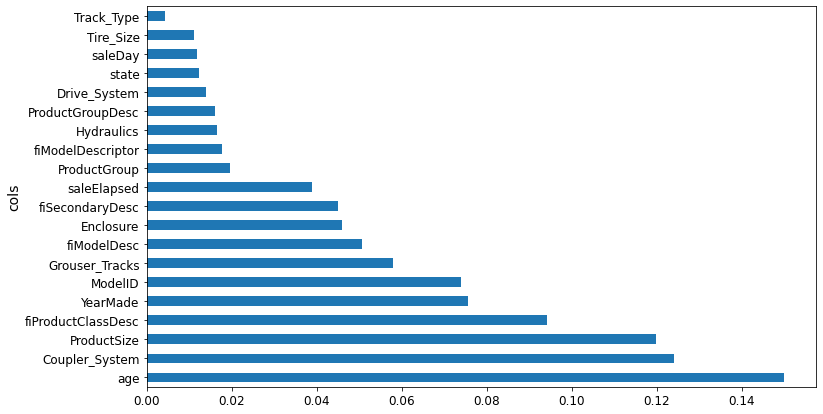

In [104]:
plot_fi(rf_feat_importance(m, X_train));

In [105]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [106]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 5s, sys: 5.58 s, total: 6min 11s
Wall time: 33.8 s
[0.08020467835631803, 0.21159142361241487, 0.9865558227661133, 0.9200452821389954, 0.9145135740066401]


As you can see, we did all of our interpretation, all of our fine-tuning basically with smaller models/subsets and at the end, we run the whole thing. And it actually still only took 16 seconds and so we’ve now got an RMSE of 0.21. Now we can check that against Kaggle. Unfortunately, this is an older competition and we are not allowed to enter anymore to see how we would have gone. So the best we can do is check whether it looks like we could have done well based on their validation set so it should be in the right area. Based on that, we would have come first.